<a href="https://colab.research.google.com/github/ShreyPandit/DCGAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:

dataroot = "./anime/"
workers = 4
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

# Getting data

Data
----

In this tutorial we will use the `Anime Faces
dataset which can
be downloaded with `Google
Drive <https://drive.google.com/file/d/1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI/view?usp=sharing>`__.




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir 'anime'
!tar zxvf '/content/drive/My Drive/data.tgz' -C './anime/'

Streaming output truncated to the last 5000 lines.
cropped/20131_2007.jpg
cropped/47683_2014.jpg
cropped/7328_2004.jpg
cropped/53270_2016.jpg
cropped/5206_2003.jpg
cropped/18522_2007.jpg
cropped/45972_2014.jpg
cropped/57454_2017.jpg
cropped/9157_2004.jpg
cropped/506_2000.jpg
cropped/18744_2007.jpg
cropped/57632_2017.jpg
cropped/9331_2004.jpg
cropped/760_2000.jpg
cropped/20357_2007.jpg
cropped/5060_2003.jpg
cropped/53016_2016.jpg
cropped/51495_2015.jpg
cropped/37388_2012.jpg
cropped/45784_2014.jpg
cropped/62002_2019.jpg
cropped/51805_2015.jpg
cropped/3525_2002.jpg
cropped/47875_2014.jpg
cropped/58685_2017.jpg
cropped/27363_2009.jpg
cropped/44703_2013.jpg
cropped/23547_2008.jpg
cropped/32086_2010.jpg
cropped/14016_2006.jpg
cropped/34953_2011.jpg
cropped/41933_2013.jpg
cropped/40127_2012.jpg
cropped/48452_2014.jpg
cropped/33892_2011.jpg
cropped/11554_2005.jpg
cropped/16377_2006.jpg
cropped/21626_2008.jpg
cropped/33402_2011.jpg
cropped/25002_2009.jpg
cropped/33664_2011.jpg
cropped/60749_20

In [0]:
from torch.utils.data import DataLoader

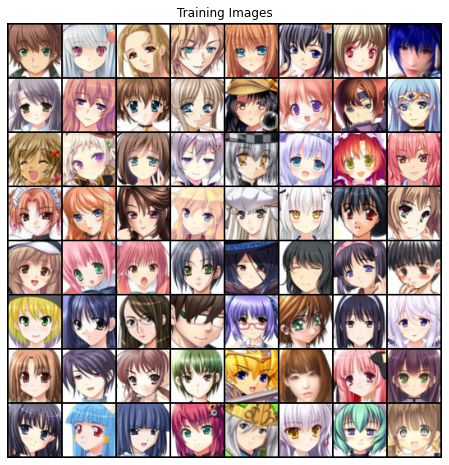

In [0]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [0]:

netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))


netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
     
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
         
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
         
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [0]:

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:

criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
from PIL import Image
from google.colab import files
cnt1 = 0
cnt2 = 0
list_curr = []
for elem in os.listdir(dataroot+'cropped/'):
  try:
    img = Image.open('anime/cropped/' + elem)
    cnt1 += 1
  except:
    list_curr.append(elem)
    cnt2 += 1
print(cnt2,cnt1)
list_curr

63 63569


['3901_2002.jpg',
 '46998_2014.jpg',
 '55695_2016.jpg',
 '38922_2012.jpg',
 '58070_2017.jpg',
 '5964_2003.jpg',
 '25213_2009.jpg',
 '36800_2012.jpg',
 '55062_2016.jpg',
 '46240_2014.jpg',
 '48378_2014.jpg',
 '55266_2016.jpg',
 '20330_2007.jpg',
 '2125_2001.jpg',
 '40505_2012.jpg',
 '32128_2010.jpg',
 '24453_2009.jpg',
 '26439_2009.jpg',
 '4118_2002.jpg',
 '35751_2011.jpg',
 '32898_2011.jpg',
 '3781_2002.jpg',
 '35611_2011.jpg',
 '27828_2009.jpg',
 '46234_2014.jpg',
 '32445_2011.jpg',
 '7058_2003.jpg',
 '21135_2008.jpg',
 '45303_2014.jpg',
 '6268_2003.jpg',
 '61050_2018.jpg',
 '20399_2007.jpg',
 '23647_2008.jpg',
 '54405_2016.jpg',
 '62823_2019.jpg',
 '20561_2008.jpg',
 '62546_2019.jpg',
 '28321_2010.jpg',
 '55382_2016.jpg',
 '26406_2009.jpg',
 '44478_2013.jpg',
 '28555_2010.jpg',
 '46529_2014.jpg',
 '1147_2001.jpg',
 '55501_2016.jpg',
 '54885_2016.jpg',
 '3651_2002.jpg',
 '6188_2003.jpg',
 '10877_2005.jpg',
 '6955_2003.jpg',
 '13131_2005.jpg',
 '26648_2009.jpg',
 '23057_2008.jpg',
 '43

In [0]:
for elem in list_curr:
  os.remove('anime/cropped/'+elem)

In [0]:

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):
        

        netD.zero_grad()
    
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = netD(real_cpu).view(-1)


        errD_real = criterion(output, label)
        
        errD_real.backward()
        D_x = output.mean().item()       

     
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
     
        fake = netG(noise)
        label.fill_(fake_label)
      
        output = netD(fake.detach()).view(-1)
       
        errD_fake = criterion(output, label)
   
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
       
        errD = errD_real + errD_fake
     
        optimizerD.step()
      
        netG.zero_grad()
        label.fill_(real_label)  

        output = netD(fake).view(-1)
    
        errG = criterion(output, label)
   
        errG.backward()
        D_G_z2 = output.mean().item()
       
        optimizerG.step()

        
      
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
    
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/5][0/497]	Loss_D: 1.4978	Loss_G: 5.3803	D(x): 0.6138	D(G(z)): 0.5501 / 0.0075
[0/5][50/497]	Loss_D: 0.1691	Loss_G: 7.7373	D(x): 0.9207	D(G(z)): 0.0006 / 0.0037
[0/5][100/497]	Loss_D: 0.9666	Loss_G: 7.4590	D(x): 0.8813	D(G(z)): 0.4581 / 0.0019
[0/5][150/497]	Loss_D: 1.1194	Loss_G: 11.5587	D(x): 0.9529	D(G(z)): 0.5666 / 0.0000
[0/5][200/497]	Loss_D: 1.8357	Loss_G: 9.2481	D(x): 0.3230	D(G(z)): 0.0007 / 0.0005
[0/5][250/497]	Loss_D: 0.5114	Loss_G: 7.1848	D(x): 0.7110	D(G(z)): 0.0102 / 0.0022
[0/5][300/497]	Loss_D: 0.5991	Loss_G: 5.0741	D(x): 0.8236	D(G(z)): 0.2259 / 0.0109
[0/5][350/497]	Loss_D: 2.9898	Loss_G: 5.5963	D(x): 0.1758	D(G(z)): 0.0008 / 0.0082
[0/5][400/497]	Loss_D: 0.6384	Loss_G: 8.8716	D(x): 0.8551	D(G(z)): 0.3036 / 0.0003
[0/5][450/497]	Loss_D: 0.3656	Loss_G: 3.5554	D(x): 0.8383	D(G(z)): 0.0563 / 0.0547
[1/5][0/497]	Loss_D: 0.4101	Loss_G: 4.8661	D(x): 0.8453	D(G(z)): 0.1573 / 0.0125
[1/5][50/497]	Loss_D: 0.2548	Loss_G: 7.0126	D(x): 0.8552	D(G(z)): 0.0536 / 0.0019
[1/5][100

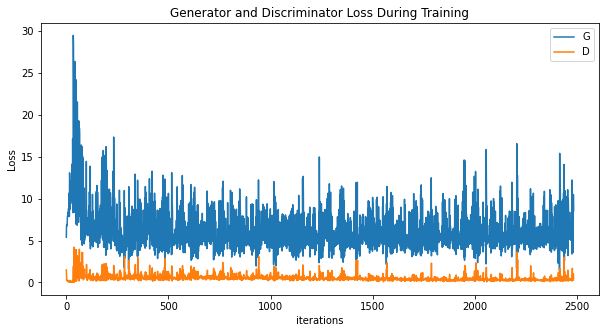

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

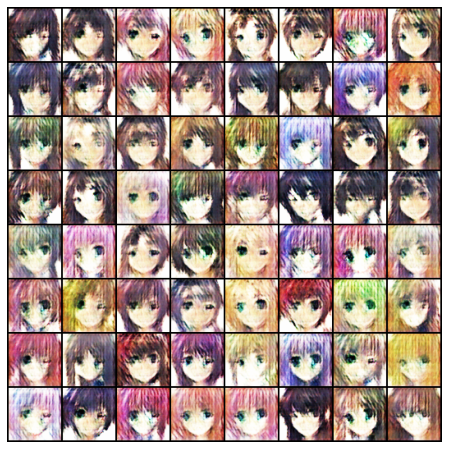

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

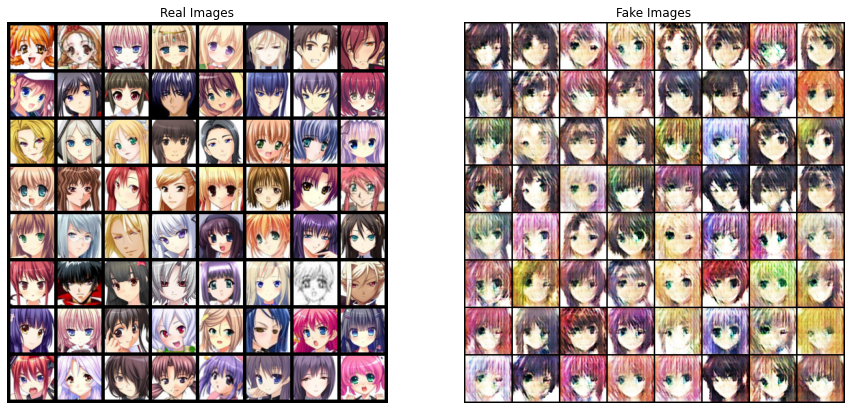

In [0]:

real_batch = next(iter(dataloader))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()